# IA Jojo

## Introdução

## Sumário

1. [Instalação de Bibliotecas](#Instalação-de-Bibliotecas)
2. [Pré processamento de Imagens](#Pré-processamento-de-Imagens)
3. [Escolha do modelo](#Escolha-do-Modelo)
4. [Treinamento do Modelo](#Treinamento-do-Modelo)
5. [Avaliação do Modelo](#Avaliação-do-Modelo)

## Instalação de Bibliotecas

Primeiramente, se ainda não foi feito, instalaremos todas as bibliotecas necessárias para esse projeto:


In [ ]:
%pip install -r requirements.txt

## Pré-processamento de Imagens

### Inicialização

Inicializamos as constantes e importamos as bibliotecas

In [1]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split

# Variável para determinar o tamanho das imagens geradas no pré-processamento
IMAGE_SIZE = 224  # Você pode ajustar este valor conforme necessário

# Definindo os caminhos
CHAR_FOLDER = Path("Characters")
IMAGE_FOLDER = CHAR_FOLDER / "Image"
AUGMENTED_TRAIN_FOLDER = CHAR_FOLDER / "Augmented_Train"

# Criar diretório para imagens aumentadas, se não existir
AUGMENTED_TRAIN_FOLDER.mkdir(parents=True, exist_ok=True)

### Aplica o Data Augmentation

Pré-processamos as imagens e criamos um dataset com as transformações de data augmentation já aplicadas e salvamos em disco

In [6]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch

# Função para salvar as imagens aumentadas
def save_augmented_images(dataset, transform, save_folder):
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        class_folder = save_folder / dataset.classes[label]
        class_folder.mkdir(parents=True, exist_ok=True)
        
        # Salvar a imagem original
        save_path = class_folder / f"{idx}_original.png"
        img.save(save_path)
        
        # Aplica as transformações e salva as imagens aumentadas
        for i in range(5):  # Aplicar e salvar 5 augmentações por imagem
            # Aplica a transformação diretamente na imagem PIL
            augmented_img = transform(img)
            # Converte o tensor aumentado para PIL
            if isinstance(augmented_img, torch.Tensor):
                augmented_img_pil = transforms.ToPILImage()(augmented_img)
            else:
                augmented_img_pil = augmented_img
            # Salvar a imagem aumentada
            save_path = class_folder / f"{idx}_{i}.png"
            augmented_img_pil.save(save_path)

# Transformações para pré-processamento das imagens
data_transforms = {
    'augment': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.ToTensor(),  # Aqui, transformamos a imagem para tensor
    ]),
    'final': transforms.Compose([
        transforms.Resize(IMAGE_SIZE + 32),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),  # Aqui, transformamos a imagem para tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Carregar o dataset original
original_dataset = datasets.ImageFolder(IMAGE_FOLDER)

# Salvar as imagens aumentadas
save_augmented_images(original_dataset, data_transforms['augment'], AUGMENTED_TRAIN_FOLDER)


d:\Desktop\Faculdade\IA-Jojo\venv\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Inicializa o dataset principal

Inicializa o dataset de treino e teste a partir do pré-processamento e data augmentation anterior. Separamos também o dataset em 2 partes na proporção de 80% para treino e 20% para teste

In [7]:
# Carregar o dataset aumentado
augmented_dataset = datasets.ImageFolder(AUGMENTED_TRAIN_FOLDER, transform=data_transforms['final'])

# Separar o dataset em treino (80%) e teste (20%)
train_size = int(0.8 * len(augmented_dataset))
test_size = len(augmented_dataset) - train_size
train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

# Criando os data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Obtendo o número de classes
class_names = augmented_dataset.classes
num_classes = len(class_names)

print(f"Classes: {class_names}")

Classes: ['Dio-Brando', 'Iggy', 'Jean-Pierre-Polnareff', 'Joseph-Joestar', 'Joutarou-Kuujou', 'Muhammad-Avdol', 'Noriaki-Kakyouin']


### Exibição de imagens

Exibimos algumas imagens para ver como está o dataset

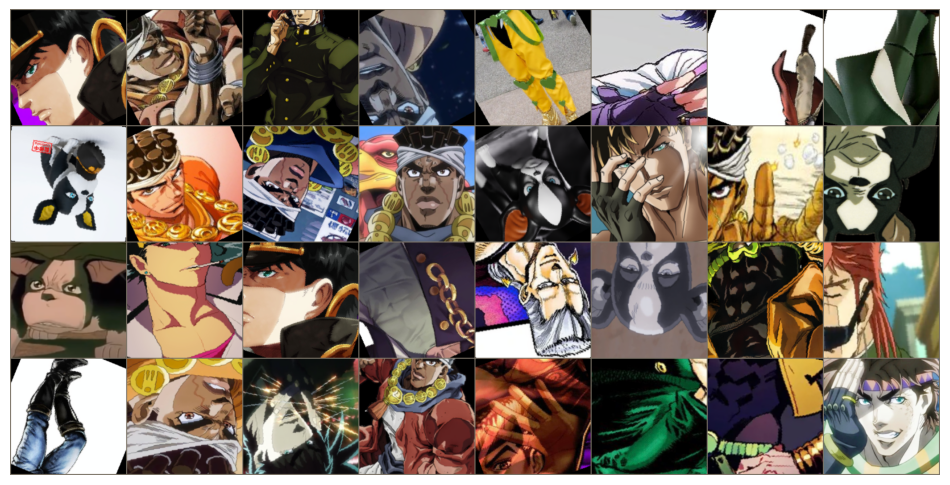

In [9]:
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np

# Função para mostrar imagens
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

# Obtendo um batch de imagens de treino
inputs, classes = next(iter(dataloaders['train']))

# Fazendo um grid de imagens
out = utils.make_grid(inputs)

# Aumentando o tamanho da figura
plt.figure(figsize=(12, 12))

# Mostrando as imagens
imshow(out)
plt.show()  # Adiciona plt.show() para garantir que as imagens sejam exibidas em alguns ambientes

## Escolha do Modelo

### Finetune do VGG16

Nessa etapas fazemos o finetune do VGG16 congelando todas as outras camadas e modificando apenas a última para o finetune. 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import VGG16_Weights

# Carregando o modelo VGG16 pré-treinado
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Congelando os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = False

# Número de características de entrada para a última camada
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Exibindo o modelo para verificar as mudanças
print(model)

## Treinamento do Modelo

### Realiza o treinamento

Realiza o treinamento e plota o gráfico dos resultados durante o treinamento, além disso ele carrega um modelo já treinado (se existir), caso não exista ele treina a partir do início, e ao final do treinamento ele salva o modelo em `model.pth`

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Definindo o dispositivo (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definindo a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

# Função para treinar o modelo
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, model_path='model.pth'):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Cada época tem uma fase de treino e uma de validação
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Definir o modelo para treinamento
            else:
                model.eval()   # Definir o modelo para validação

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Somente faça cálculo de gradiente na fase de treinamento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation e otimização na fase de treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Armazenar a perda e precisão para plotagem
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)

            # Salvar o melhor modelo
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        # Atualizar gráficos dinamicamente
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_acc_history, label='Train Acc')
        plt.plot(val_acc_history, label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        display(plt.gcf())

    print(f'Best val Acc: {best_acc:.4f}')

    # Carregar os melhores pesos do modelo
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    torch.save(model.state_dict(), model_path)

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Carregar o modelo salvo, se existir
model_path = 'model.pth'
if Path(model_path).exists():
    model.load_state_dict(torch.load(model_path))

# Treinar o modelo
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history  = train_model(model, dataloaders, criterion, optimizer, num_epochs=25, model_path=model_path)

Epoch 0/24
----------
train Loss: 1.9979 Acc: 0.2277
test Loss: 1.7332 Acc: 0.2308
Epoch 1/24
----------
train Loss: 1.8952 Acc: 0.3036
test Loss: 1.6128 Acc: 0.2769
Epoch 2/24
----------
train Loss: 1.6437 Acc: 0.3527
test Loss: 1.6194 Acc: 0.3692
Epoch 3/24
----------
train Loss: 1.5659 Acc: 0.4062
test Loss: 1.5800 Acc: 0.3385
Epoch 4/24
----------
train Loss: 1.4889 Acc: 0.4554
test Loss: 1.5721 Acc: 0.3692
Epoch 5/24
----------
train Loss: 1.4049 Acc: 0.5000
test Loss: 1.4960 Acc: 0.5077
Epoch 6/24
----------
train Loss: 1.3576 Acc: 0.5312
test Loss: 1.6240 Acc: 0.3692
Epoch 7/24
----------
train Loss: 1.4255 Acc: 0.4554
test Loss: 1.5682 Acc: 0.4462
Epoch 8/24
----------
train Loss: 1.3853 Acc: 0.4732
test Loss: 1.5022 Acc: 0.4615
Epoch 9/24
----------
train Loss: 1.3990 Acc: 0.4955
test Loss: 1.4700 Acc: 0.4308
Epoch 10/24
----------
train Loss: 1.4334 Acc: 0.4241
test Loss: 1.4869 Acc: 0.4615
Epoch 11/24
----------
train Loss: 1.3199 Acc: 0.5268
test Loss: 1.3564 Acc: 0.5077
Ep

## Avaliação do Modelo

### Métricas

Agora avaliamos nosso modelo medindo acurácia, precisão, recall e F1-score. Além obtemos e plotamos a matriz de confusão.

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloaders):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Chamar a função para plotar a matriz de confusão
plot_confusion_matrix(model, dataloaders)


def evaluate_model(model, dataloaders):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    # Plotar a matriz de confusão
    plot_confusion_matrix(model, dataloaders)

    return accuracy, precision, recall, f1

# Avaliar o modelo
accuracy, precision, recall, f1 = evaluate_model(model, dataloaders)

Test Accuracy: 0.5692


### Plotagem dos Gráficos


#### Métricas Gerais

Agora plotamos os gráficos das métricas gerais

In [ ]:
def plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history, accuracy, precision, recall, f1):
    epochs = range(len(train_loss_history))

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_acc_history, label='Train Acc')
    plt.plot(epochs, val_acc_history, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.bar(['Accuracy', 'Precision', 'Recall', 'F1-Score'], [accuracy, precision, recall, f1])
    plt.ylim(0, 1)
    plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

# Chamar a função de plotagem das métricas
plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history, accuracy, precision, recall, f1)


#### Métricas por Classe

Agora plotamos um gráfico separado por classe

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model_per_class(model, dataloaders, class_names):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics per class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot precision, recall, and F1 score
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].bar(class_names, precision, color='blue')
    axes[0].set_title('Precision by Class')
    axes[0].set_xticklabels(class_names, rotation=90)

    axes[1].bar(class_names, recall, color='green')
    axes[1].set_title('Recall by Class')
    axes[1].set_xticklabels(class_names, rotation=90)

    axes[2].bar(class_names, f1, color='red')
    axes[2].set_title('F1 Score by Class')
    axes[2].set_xticklabels(class_names, rotation=90)
    
    plt.tight_layout()
    plt.show()


evaluate_model_per_class(model, dataloaders, class_names)